In [1]:
import string
import spacy
spacy_nlp = spacy.load("en_core_web_sm")
import numpy as np
from spacy.lang.en.stop_words import STOP_WORDS
import utility_functions as utils
import importlib
import pandas as pd
import matplotlib.pyplot as plt

# Octis is the library which can use different implemented topic modelling techniques
from octis.preprocessing.preprocessing import Preprocessing
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.models.CTM import CTM

importlib.reload(utils)

data = '/Users/borosabel/Documents/Uni/Thesis/PopMIR/Data/Audio/test.json'

custom_stop_words = list(STOP_WORDS)  # Existing stop words
custom_stop_words.extend(["ll", "ve", "'em", "em", "ho", "fo", "ah", "de"])  # Tokens which doesn't really make sense to have them.

/Users/borosabel/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
df = pd.read_excel('/Users/borosabel/Documents/Uni/Thesis/PopMIR/Code/Audio/baseline_data.xlsx', engine='openpyxl')

In [3]:
df['Lyrics'] = df['Lyrics'].apply(utils.cleanup)

In [4]:
with open('corpus.tsv', 'w', encoding='utf-8') as file:
    for lyrics in df['Lyrics']:
        if pd.notna(lyrics):  # Check if the lyrics data is not NaN
            file.write(lyrics + '\n')

In [6]:
# Initialize preprocessing
preprocessor = Preprocessing(
    vocabulary=None,
    max_features=None,
    remove_punctuation=True,
    punctuation=string.punctuation,
    lemmatize=True,
    stopword_list=custom_stop_words,
    min_chars=2,
    min_words_docs=0,
    save_original_indexes=True,
    min_df=0.05, # a term must appear in at least 5% of the documents; otherwise, it will be discarded.
    max_df=0.8, # a term appearing in more than 80% of the documents will be discarded, as it might be too common and potentially less informative.
    split=False # We don't want train, validation and test split
)

dataset = preprocessor.preprocess_dataset(documents_path="/Users/borosabel/Documents/Uni/Thesis/PopMIR/Code/Lyrics/octis_dataset/corpus.tsv")

100%|██████████| 1368/1368 [02:00<00:00, 11.31it/s]


created vocab
645


<b>As you can see there are 658 unique words in the vocabulary</b>

In [7]:
# I save the dataset because it exports a file called indexes.txt. It is important because during the preprocessing steps the preprocessor
# can get rid of a few documents if they don't have enough words or maybe they are too short. (For example intro files).
# I can load the indexes.txt file and use it as a list of indexes and apply it on the original dataframe so I don't have size mismatch.
dataset.save('./')

In [8]:
best_coherence = -1
best_params = {}
topic_nums = [2, 3, 4, 5, 10, 15]
epoch_nums = [100, 200, 300]

for num_topics in topic_nums:
    for num_epochs in epoch_nums:
        model = CTM(num_topics=num_topics, inference_type="combined", num_epochs=num_epochs, use_partitions=False, bert_model="bert-base-nli-mean-tokens")
        model_output = model.train_model(dataset)
        # Assuming the model has a method to compute coherence
        coherence = Coherence(texts=dataset.get_corpus(), topk=10)  # Adjust 'topk' as needed
        # Setting up Diversity Metric
        topic_diversity = TopicDiversity(topk=10)
        # Calculate Metrics
        coherence = coherence.score(model_output)

        if coherence > best_coherence:
            best_coherence = coherence
            best_params = {'num_topics': num_topics, 'num_epochs': num_epochs}

print(f"Best Coherence: {best_coherence}")
print(f"Best Parameters: {best_params}")

Best Coherence: 0.023616748019630183
Best Parameters: {'num_topics': 2, 'num_epochs': 300}


In [10]:
model = CTM(num_topics=best_params['num_topics'], inference_type="combined", num_epochs=best_params['num_epochs'], use_partitions=False, bert_model="bert-base-nli-mean-tokens")
model_output = model.train_model(dataset)

In [11]:
model_output['topics'][0] # Vulgarity

['nigga',
 'bitch',
 'bust',
 'shit',
 'fuck',
 'fucking',
 'baby',
 'let',
 'ride',
 'right']

In [12]:
model_output['topics'][1]

['rhyme',
 'people',
 'dance',
 'la',
 'music',
 'rhythm',
 'sound',
 'ooh',
 'soul',
 'tip']

In [13]:
# model_output['topics'][2] # Romance

In [14]:
# model_output['topics'][3] # Music

In [15]:
# model_output['topics'][4] # Day, Street-Life, Struggle

In [16]:
coherence = Coherence(texts=dataset.get_corpus(), topk=10)  # Adjust 'topk' as needed

# Setting up Diversity Metric
topic_diversity = TopicDiversity(topk=10)

# Calculate Metrics
coherence_score = coherence.score(model_output)
diversity_score = topic_diversity.score(model_output)

print("Coherence Score:", coherence_score)
print("Diversity Score:", diversity_score)

Coherence Score: 0.013335900465097313
Diversity Score: 1.0


<b>Let's check which document belongs mostly to which topic</b>

In [17]:
model_output['topic-document-matrix']

array([[0.81044566, 0.97014826, 0.19725078, ..., 0.81349054, 0.79708362,
        0.97080759],
       [0.18955433, 0.02985172, 0.80274922, ..., 0.18650947, 0.20291638,
        0.02919243]])

In [18]:
# We decide on the topic based on the maximum probability of the topic.
dominant_topic_indices = np.argmax(model_output['topic-document-matrix'], axis=0)

In [19]:
# Every row is a document and the colum shows which is the most probable topic index.
dominant_topic_indices

array([0, 0, 1, ..., 0, 0, 0])

In [20]:
# We load the previously saved indexes file because in this way we can filter the documents by index. Some documents may not included in the analysis due to the preprocessing steps
file_path = 'indexes.txt'

# Read the file and convert each line to an integer
with open(file_path, 'r') as file:
    indices = [int(line.strip()) for line in file]

In [21]:
# We have 1368 rows in the original dataset
df

,Artist,Album,Song,Coast,Release Year,Tempo1,Tempo2,Duration (s),Sample Rate (Hz),Path,Lyrics
0,Big L,Lifestylez Ov Da Poor and Dangerous,8 Iz Enuff.mp3,east_coast,1995,96.774194,48.000000,298.840000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,yeah my crew be in the house terra herb mcgruf...
1,Big L,Lifestylez Ov Da Poor and Dangerous,Da Graveyard.mp3,east_coast,1995,93.750000,46.511628,323.760000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,it be the number one crew in the area big l be...
2,Big L,Lifestylez Ov Da Poor and Dangerous,I Don't Understand It.mp3,east_coast,1995,93.750000,47.244094,260.226667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,there be too many mc 's who be overrate yeah a...
3,Big L,Lifestylez Ov Da Poor and Dangerous,"No Endz, No Skinz.mp3",east_coast,1995,100.000000,50.420168,208.733333,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,let I get to the point real quick when yeah po...
4,Big L,Lifestylez Ov Da Poor and Dangerous,MVP.mp3,east_coast,1995,86.956522,43.478261,218.866667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,a yeah spark up the phillie and pass the stout...
...,...,...,...,...,...,...,...,...,...,...,...
1363,Dr.Dre,The Chronic,Dr. Dre - The Day the Niggaz Took Over (feat. ...,west_coast,1992,93.750000,46.875000,273.206000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,I be a say this and I be a end mine if yeah be...
1364,Dr.Dre,The Chronic,"Dr. Dre - Bitches Ain't Shit (feat. Jewell, Sn...",west_coast,1992,92.307692,46.153846,287.207625,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,bitch be not shit but hoe and trick bitch be n...
1365,Dr.Dre,The Chronic,Dr. Dre - Stranded On Death Row (feat. Bushwic...,west_coast,1992,90.909091,45.801527,287.335333,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,yes it be I say I and all who agree be more th...
1366,Dr.Dre,The Chronic,Dr. Dre - Nuthin' but a ＂G＂ Thang (feat. Snoop...,west_coast,1992,95.238095,47.244094,238.677917,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,one two three and to the four snoop doggy dogg...


In [22]:
filtered_df = df.iloc[indices]

In [23]:
filtered_df

,Artist,Album,Song,Coast,Release Year,Tempo1,Tempo2,Duration (s),Sample Rate (Hz),Path,Lyrics
0,Big L,Lifestylez Ov Da Poor and Dangerous,8 Iz Enuff.mp3,east_coast,1995,96.774194,48.000000,298.840000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,yeah my crew be in the house terra herb mcgruf...
1,Big L,Lifestylez Ov Da Poor and Dangerous,Da Graveyard.mp3,east_coast,1995,93.750000,46.511628,323.760000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,it be the number one crew in the area big l be...
2,Big L,Lifestylez Ov Da Poor and Dangerous,I Don't Understand It.mp3,east_coast,1995,93.750000,47.244094,260.226667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,there be too many mc 's who be overrate yeah a...
3,Big L,Lifestylez Ov Da Poor and Dangerous,"No Endz, No Skinz.mp3",east_coast,1995,100.000000,50.420168,208.733333,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,let I get to the point real quick when yeah po...
4,Big L,Lifestylez Ov Da Poor and Dangerous,MVP.mp3,east_coast,1995,86.956522,43.478261,218.866667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,a yeah spark up the phillie and pass the stout...
...,...,...,...,...,...,...,...,...,...,...,...
1363,Dr.Dre,The Chronic,Dr. Dre - The Day the Niggaz Took Over (feat. ...,west_coast,1992,93.750000,46.875000,273.206000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,I be a say this and I be a end mine if yeah be...
1364,Dr.Dre,The Chronic,"Dr. Dre - Bitches Ain't Shit (feat. Jewell, Sn...",west_coast,1992,92.307692,46.153846,287.207625,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,bitch be not shit but hoe and trick bitch be n...
1365,Dr.Dre,The Chronic,Dr. Dre - Stranded On Death Row (feat. Bushwic...,west_coast,1992,90.909091,45.801527,287.335333,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,yes it be I say I and all who agree be more th...
1366,Dr.Dre,The Chronic,Dr. Dre - Nuthin' but a ＂G＂ Thang (feat. Snoop...,west_coast,1992,95.238095,47.244094,238.677917,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,one two three and to the four snoop doggy dogg...


In [24]:
# This is just to make sure that in the filtered dataframe we have the same ammount of songs than in the preprocessed dataset.
filtered_df.shape[0] == dominant_topic_indices.shape[0]

True

In [25]:
filtered_df['Topic Model'] = dominant_topic_indices

/var/folders/99/617f3z715_g8nc26tll89ddc0000gn/T/ipykernel_14319/1676926741.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Topic Model'] = dominant_topic_indices


In [26]:
filtered_df.head()

,Artist,Album,Song,Coast,Release Year,Tempo1,Tempo2,Duration (s),Sample Rate (Hz),Path,Lyrics,Topic Model
0,Big L,Lifestylez Ov Da Poor and Dangerous,8 Iz Enuff.mp3,east_coast,1995,96.774194,48.000000,298.840000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,yeah my crew be in the house terra herb mcgruf...,0
1,Big L,Lifestylez Ov Da Poor and Dangerous,Da Graveyard.mp3,east_coast,1995,93.750000,46.511628,323.760000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,it be the number one crew in the area big l be...,0
2,Big L,Lifestylez Ov Da Poor and Dangerous,I Don't Understand It.mp3,east_coast,1995,93.750000,47.244094,260.226667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,there be too many mc 's who be overrate yeah a...,1
3,Big L,Lifestylez Ov Da Poor and Dangerous,"No Endz, No Skinz.mp3",east_coast,1995,100.000000,50.420168,208.733333,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,let I get to the point real quick when yeah po...,0
4,Big L,Lifestylez Ov Da Poor and Dangerous,MVP.mp3,east_coast,1995,86.956522,43.478261,218.866667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,a yeah spark up the phillie and pass the stout...,0


In [27]:
# Save the data:
# filtered_df.to_excel("baseline_data_w_topics.xlsx", sheet_name="Sheet1", index=False)

<b>Check The Topic Distribution</b>

In [28]:
topic_coast_distribution = pd.crosstab(filtered_df['Topic Model'], filtered_df['Coast'])
print(topic_coast_distribution)

Coast        east_coast  west_coast
Topic Model                        
0                   285         458
1                   413         208


In [29]:
# Normalization of the topic distribution over the entire dataset
total_songs = topic_coast_distribution.sum().sum()
topic_coast_distribution_normalized = topic_coast_distribution / total_songs

Here we can see that one of the topic's large contributors are the west coast songs.
Also there should be a topic where the east coast contribution is larger than the west coast contribution.
The other 

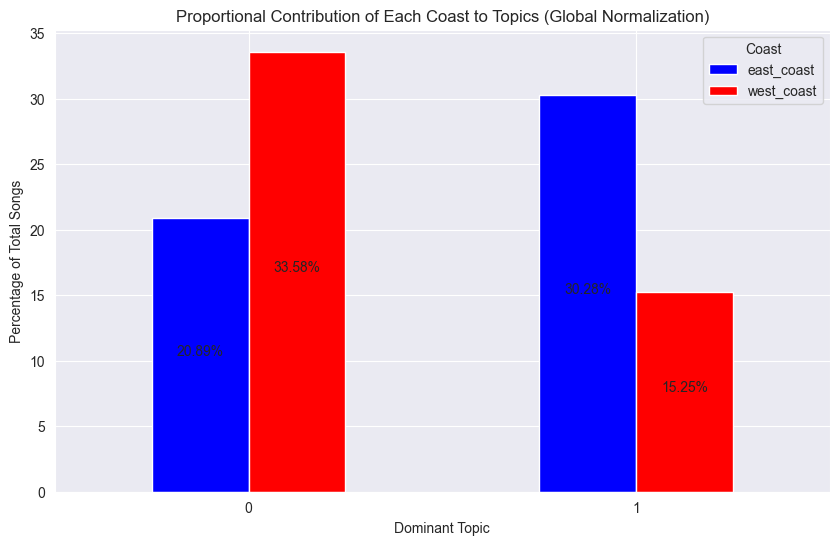

In [30]:
colors = ['blue', 'red']
ax = (topic_coast_distribution_normalized * 100).plot(kind='bar', figsize=(10, 6), color=colors)
plt.title('Proportional Contribution of Each Coast to Topics (Global Normalization)')
plt.xlabel('Dominant Topic')
plt.ylabel('Percentage of Total Songs')
plt.xticks(rotation=0)
plt.legend(title='Coast')

# Adding percentage labels
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    if height > 0:  # Only add annotations for non-zero values
        ax.annotate(f'{height:.2f}%', (x + width/2, y + height*0.5), ha='center')

plt.show()

<b>Let's check the characteristics of the two topics which has huge differences between the coast distributions.</b>

In [41]:
topic2_df = filtered_df[filtered_df['Topic Model'] == 0]
topic4_df = filtered_df[filtered_df['Topic Model'] == 1]

<b>Vulgarity/Bad Words Topic</b>

In [42]:
topic2_artists = topic2_df[['Artist', 'Coast']]

In [43]:
topic2_artist_topic_distribution = pd.crosstab(topic2_artists['Artist'], topic2_artists['Coast'])
print(topic2_artist_topic_distribution)

Coast                 east_coast  west_coast
Artist                                      
A Tribe Called Quest           8           0
Beastie Boys                   8           0
Big L                          6           0
Busta Rhymes                  40           0
Coolio                         0          24
Cypress Hill                   0          20
De La Soul                    14           0
Digital Underground            0          11
Dr.Dre                         0          20
Eazy-E                         0          23
Erik B and Rakim               7           0
Gang Starr                     8           0
Ice Cube                       0          31
Ice-T                          0          46
Jay-Z                         35           0
LL cool J                     27           0
Luniz                          0          12
Mobb Deep                     28           0
N.W.A                          0          31
Nas                           22           0
Pac       

In [44]:
total_songs_in_topic2 = topic2_artist_topic_distribution.sum().sum()
topic2_coast_distribution_normalized = topic2_artist_topic_distribution / total_songs_in_topic2

<b>Here we can see that the biggest contributor artists to this topic is Ice Cube, Too Short, Eazy-E</b>

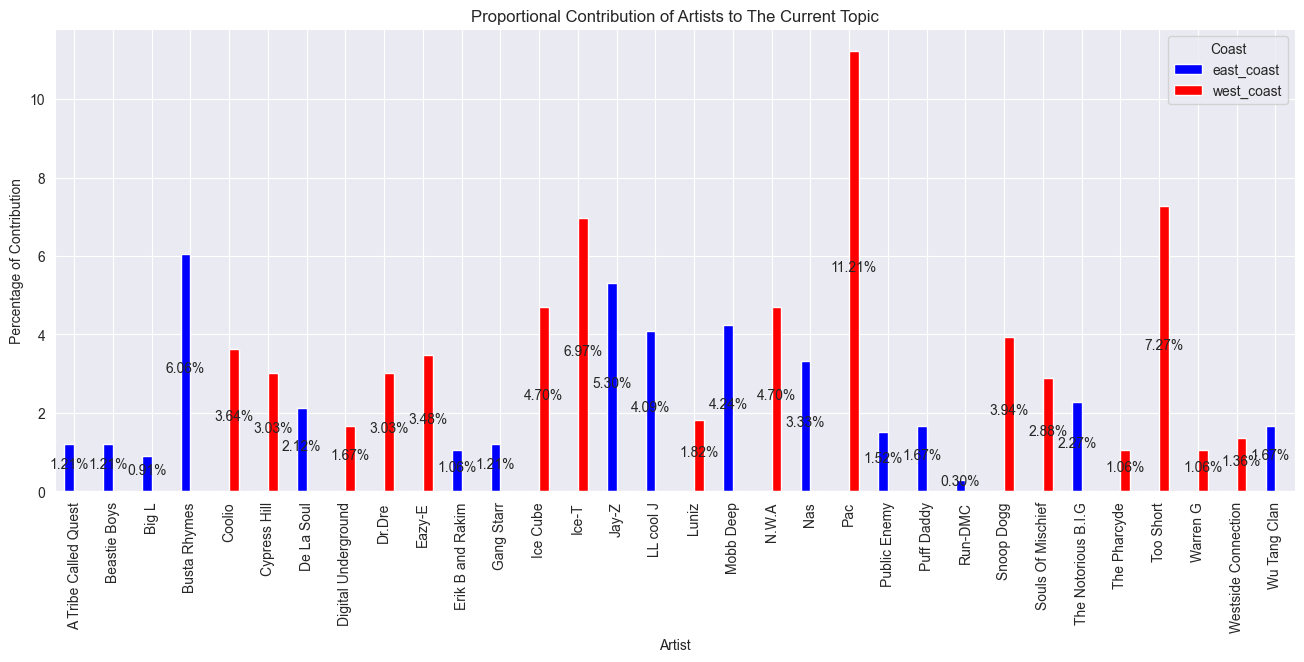

In [45]:
colors = ['blue', 'red']
ax = (topic2_coast_distribution_normalized * 100).plot(kind='bar', figsize=(16, 6), color=colors)
plt.title('Proportional Contribution of Artists to The Current Topic')
plt.xlabel('Artist')
plt.ylabel('Percentage of Contribution')
plt.xticks(rotation=90)
plt.legend(title='Coast')

# Adding percentage labels
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    if height > 0:  # Only add annotations for non-zero values
        ax.annotate(f'{height:.2f}%', (x + width/2, y + height*0.5), ha='center')

plt.show()

In [46]:
topic4_artists = topic4_df[['Artist', 'Coast']]

In [47]:
topic4_artist_topic_distribution = pd.crosstab(topic4_artists['Artist'], topic4_artists['Coast'])
print(topic4_artist_topic_distribution)

Coast                 east_coast  west_coast
Artist                                      
A Tribe Called Quest          49           0
Beastie Boys                  54           0
Big L                          6           0
Busta Rhymes                   6           0
Coolio                         0          25
Cypress Hill                   0          24
De La Soul                    67           0
Digital Underground            0          36
Dr.Dre                         0           5
Eazy-E                         0          10
Erik B and Rakim              32           0
Gang Starr                    50           0
Ice Cube                       0          24
Ice-T                          0          52
Jay-Z                          6           0
LL cool J                     45           0
Luniz                          0           2
Mobb Deep                      4           0
N.W.A                          0          10
Nas                            2           0
Pac       

In [48]:
total_songs_in_topic4 = topic4_artist_topic_distribution.sum().sum()
topic4_coast_distribution_normalized = topic4_artist_topic_distribution / total_songs_in_topic4

<b>At this topic the east coast artists gets distributed in a much more equal way. Most of the artist contributes to the topic from 6 to 10%</b>

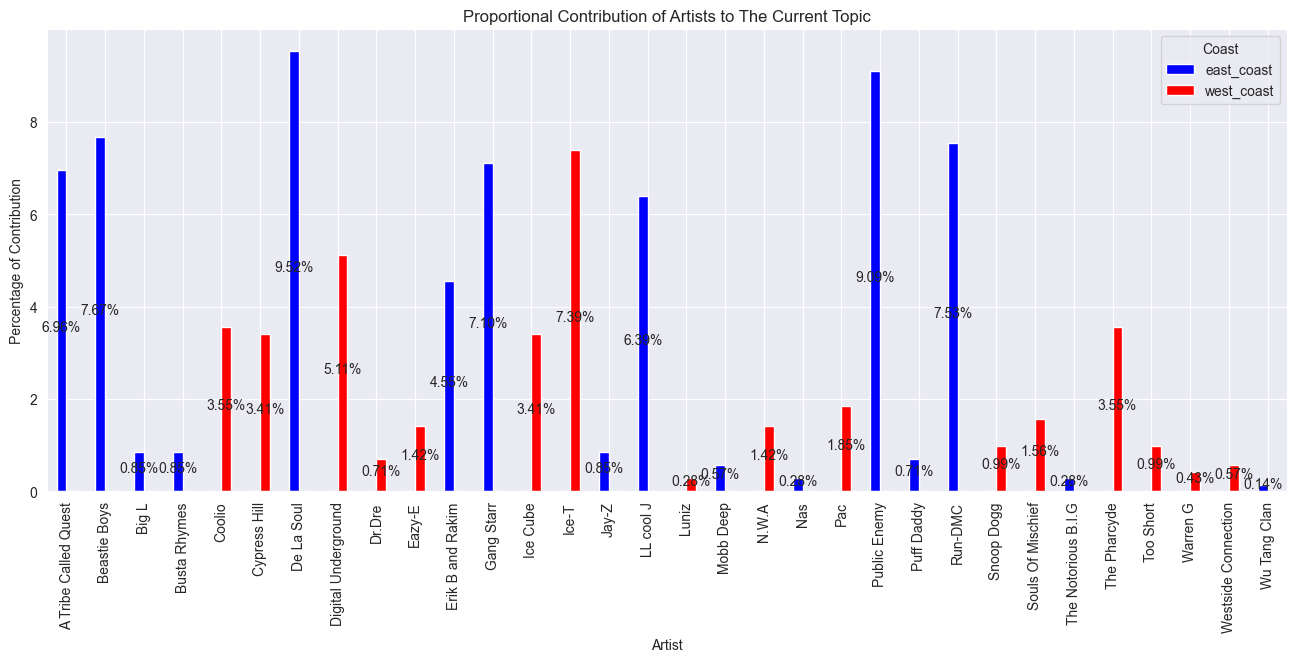

In [49]:
colors = ['blue', 'red']
ax = (topic4_coast_distribution_normalized * 100).plot(kind='bar', figsize=(16, 6), color=colors)
plt.title('Proportional Contribution of Artists to The Current Topic')
plt.xlabel('Artist')
plt.ylabel('Percentage of Contribution')
plt.xticks(rotation=90)
plt.legend(title='Coast')

# Adding percentage labels
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    if height > 0:  # Only add annotations for non-zero values
        ax.annotate(f'{height:.2f}%', (x + width/2, y + height*0.5), ha='center')

plt.show()

In [144]:
artist_topic_distribution = pd.crosstab(df_artists_only['Artist'], df_artists_only['Topic Model'])
print(artist_topic_distribution)

Topic Model            0   1   2   3   4
Artist                                  
Dr.Dre                 9   2   5   3  10
a_tribe_called_quest   1  25  15  14   2
beastie_boys           4  38  20  26   0
big_l                  4   1   1   4   2
busta_rhymes           3   2   8   1  32
coolio                16  16   6   3   8
cypress_hill          12  16   9   5   7
de_la_soul             0  34  26  28   2
digital_underground    1  15  11  20   0
eazy_e                20   4   3   8   9
erikb_&_rakim          1   8   1  29   0
gang_starr             2  18   2  32   4
ice-t                 20  25  12  18  13
ice_cube              38  21   3   1   3
jay-z                 11   3   2   3  24
ll_cool_j              0  13  26  33   4
luniz                 10   1   0   0   3
mack_10                9   1   0   1   3
mobb_deep              2   5   1   2  30
nas                    0   0   4   3  18
nwa                   23   3   4   4   8
pac                   12   3  24  13  70
public_enemy    

/var/folders/99/617f3z715_g8nc26tll89ddc0000gn/T/ipykernel_27757/1413891858.py:11: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.barplot(x='Artist', y='Number of Songs', hue='Topic Model', data=df_melted, palette=palette)


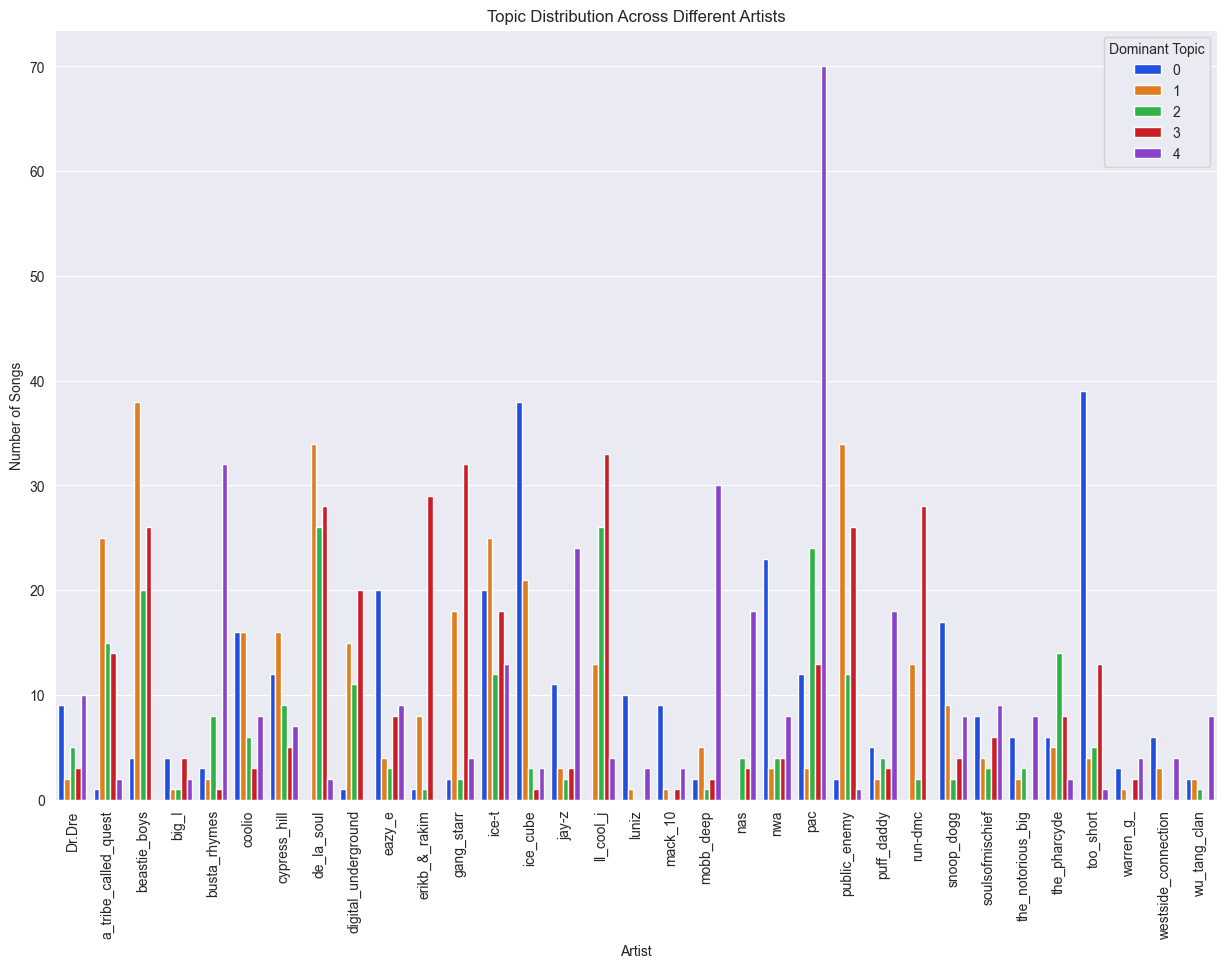

In [152]:
import seaborn as sns

# Reset index to use "Artist" as a normal column
df_melted = artist_topic_distribution.reset_index().melt(id_vars='Artist', value_name='Number of Songs', var_name='Topic Model')

# Using a predefined palette
palette = sns.color_palette("bright")  # You can change "pastel" to "deep", "muted", "bright", "dark", or "colorblind"

# Create the plot
plt.figure(figsize=(15, 10))
sns.barplot(x='Artist', y='Number of Songs', hue='Topic Model', data=df_melted, palette=palette)
plt.title('Topic Distribution Across Different Artists')
plt.xlabel('Artist')
plt.ylabel('Number of Songs')
plt.xticks(rotation=90)  # Rotate labels to make them readable
plt.legend(title='Dominant Topic')
plt.show()

In [155]:
topic_word_matrix = model_output['topic-word-matrix']

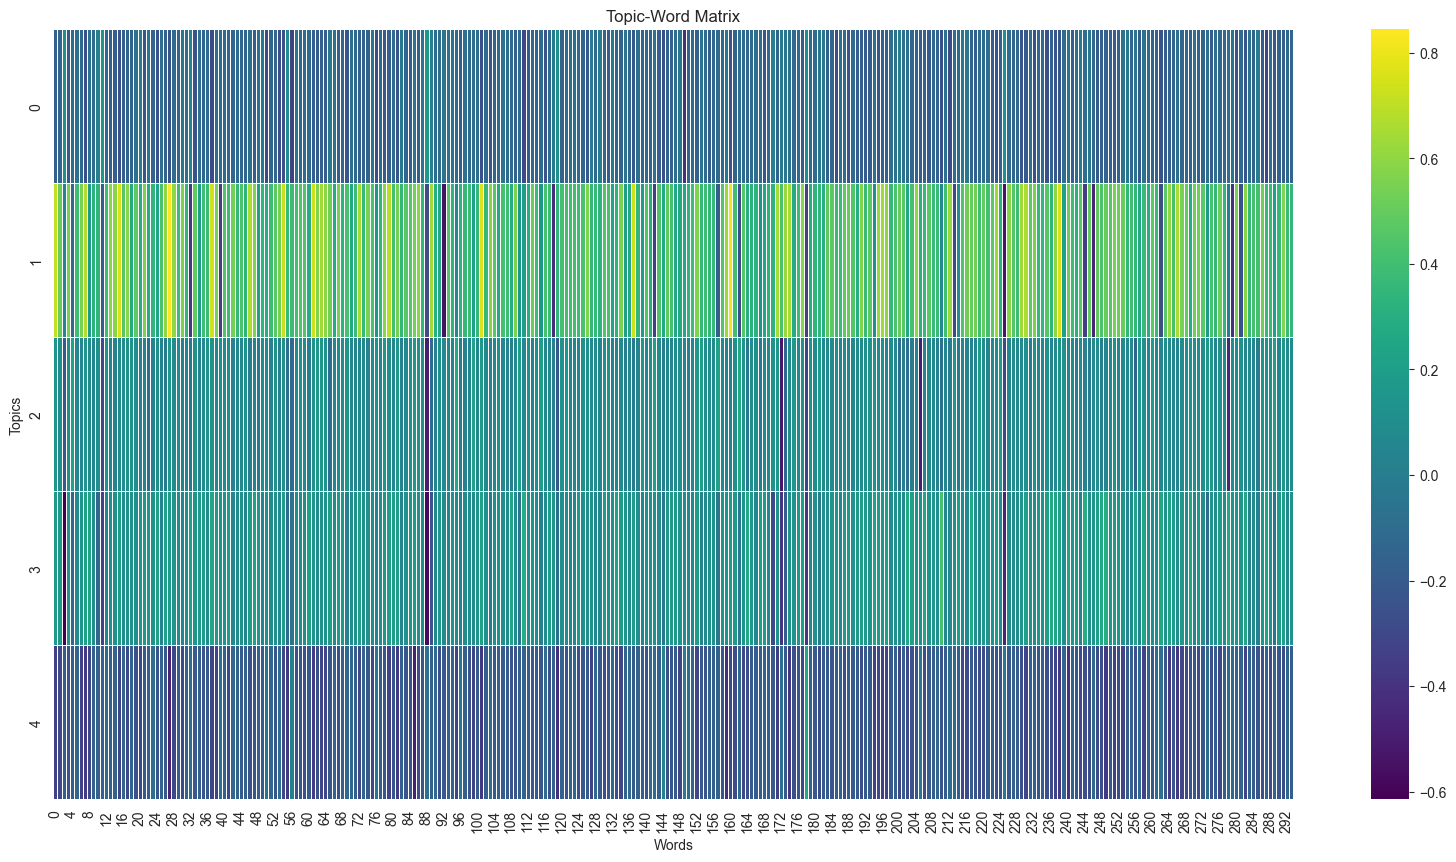

In [158]:
plt.figure(figsize=(20, 10))
sns.heatmap(topic_word_matrix, cmap='viridis', linewidths=.5)
plt.title('Topic-Word Matrix')
plt.xlabel('Words')
plt.ylabel('Topics')
plt.show()

In [7]:
best_coherence = -1
best_params = {}
topic_nums = [5, 10, 15]
epoch_nums = [100, 200, 300]

for num_topics in topic_nums:
    for num_epochs in epoch_nums:
        model = CTM(num_topics=num_topics, inference_type="combined", num_epochs=num_epochs, use_partitions=False, bert_model="bert-base-nli-mean-tokens")
        model_output = model.train_model(dataset)
        # Assuming the model has a method to compute coherence
        coherence = Coherence(texts=dataset.get_corpus(), topk=10)  # Adjust 'topk' as needed
        # Setting up Diversity Metric
        topic_diversity = TopicDiversity(topk=10)
        # Calculate Metrics
        coherence = coherence.score(model_output)

        if coherence > best_coherence:
            best_coherence = coherence
            best_params = {'num_topics': num_topics, 'num_epochs': num_epochs}

print(f"Best Coherence: {best_coherence}")
print(f"Best Parameters: {best_params}")

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Best Coherence: 0.02905395765279088
Best Parameters: {'num_topics': 5, 'num_epochs': 300}


In [41]:
model_output

{'topics': [['count',
   'suppose',
   'dip',
   'rich',
   'load',
   'police',
   'glock',
   'fire',
   'getting',
   'bullshit'],
  ['rhyme',
   'mic',
   'mc',
   'watch',
   'cool',
   'count',
   'suppose',
   'sucker',
   'sound',
   'rap'],
  ['nigga',
   'shit',
   'die',
   'life',
   'live',
   'god',
   'thug',
   'fuck',
   'motherfucker',
   'pain'],
  ['bitch',
   'fuck',
   'shit',
   'nigga',
   'dick',
   'cause',
   'ass',
   'hoe',
   'pimp',
   'pussy'],
  ['baby',
   'girl',
   'love',
   'let',
   'lady',
   'meet',
   'man',
   'hey',
   'world',
   'woman']],
 'topic-document-matrix': array([[0.14888467, 0.06934158, 0.06180276, ..., 0.03603857, 0.18080038,
         0.14472517],
        [0.2914982 , 0.11448529, 0.57811195, ..., 0.09502198, 0.22802945,
         0.11112121],
        [0.31442441, 0.34921903, 0.12986823, ..., 0.31811446, 0.18106172,
         0.16332806],
        [0.17011587, 0.37094741, 0.08037342, ..., 0.5195852 , 0.29761671,
         0.42625716],

In [78]:
# Assuming `model` is your trained topic model from OCTIS
topic_word_matrix = model_output['topic-word-matrix']
topic_document_matrix = model_output['topic-document-matrix']
vocabulary = dataset.get_vocabulary()
document_ids = range(len(topic_document_matrix[0]))  # Adjust based on how you've stored documents

# Assuming topic_document_matrix is an array where rows are topics and columns are documents
topic_sizes = np.sum(topic_document_matrix, axis=1)  # Sum over columns to get size per topic
normalized_sizes = (topic_sizes - np.min(topic_sizes)) / (np.max(topic_sizes) - np.min(topic_sizes)) * 100 + 10  # Normalize and scale

In [79]:
# Prepare top 10 words for tooltips
top_words_per_topic = []
for idx in range(len(topic_word_matrix)):
    top_words = sorted([(vocabulary[i], weight) for i, weight in enumerate(topic_word_matrix[idx])],
                       key=lambda x: x[1], reverse=True)[:10]  # Get top 10 words
    top_words_per_topic.append(", ".join([word for word, weight in top_words]))

In [74]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_results = tsne_model.fit_transform(topic_word_matrix)

/Users/borosabel/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/borosabel/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Indexed 5 samples in 0.000s...
[t-SNE] Computed neighbors for 5 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 5 / 5
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 35.654984
[t-SNE] KL divergence after 750 iterations: 0.103591


In [87]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()

for idx, coords in enumerate(tsne_results):
    topic_label = f"Topic {idx}"
    tooltip_info = f"{topic_label}: {top_words_per_topic[idx]}"

    fig.add_trace(go.Scatter(
        x=[coords[0]],
        y=[coords[1]],
        name=topic_label,
        marker=dict(size=normalized_sizes[idx]),  # Use normalized sizes for marker size
        text=tooltip_info,
        hoverinfo='text'
    ))

fig.update_layout(title="Topic Visualization",
                  xaxis_title="Component 1",
                  yaxis_title="Component 2",
                  hovermode='closest')
fig.show()

In [81]:
model_output['topics']

[['bitch',
  'fuck',
  'shit',
  'nigga',
  'dick',
  'hoe',
  'cause',
  'ass',
  'pimp',
  'pussy'],
 ['motherfucke',
  'level',
  'second',
  'cream',
  'taste',
  'jail',
  'gat',
  'doin',
  'fade',
  'park'],
 ['rhyme',
  'lyric',
  'mc',
  'step',
  'hip',
  'sucker',
  'level',
  'style',
  'song',
  'rap'],
 ['man', 'baby', 'girl', 'love', 'let', 'woman', 'uh', 'hey', 'head', 'feel'],
 ['nigga',
  'shit',
  'die',
  'live',
  'life',
  'fuck',
  'motherfucker',
  'thug',
  'la',
  'gun']]

In [88]:
unique_topics = np.unique(filtered_df['Topic Model'])

In [90]:
document_topic_matrix = topic_document_matrix.T

# Apply t-SNE to the document-topic matrix
tsne = TSNE(n_components=2, random_state=42)
document_tsne_results = tsne.fit_transform(document_topic_matrix)

/Users/borosabel/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/borosabel/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [89]:
colors = px.colors.qualitative.Set1  # Using Plotly's qualitative color sets
topic_color_map = {topic: colors[i % len(colors)] for i, topic in enumerate(unique_topics)}
filtered_df['color'] = filtered_df['Topic Model'].map(topic_color_map)

/var/folders/99/617f3z715_g8nc26tll89ddc0000gn/T/ipykernel_62803/3588960685.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [92]:
import plotly.express as px

fig = px.scatter(
    filtered_df,
    x=document_tsne_results[:, 0],
    y=document_tsne_results[:, 1],
    color=filtered_df['Topic Model'].astype(str),  # Convert topics to string for coloring
    hover_data=['Song', 'Artist'],  # Assuming these columns exist in _df
    title="Songs in 2D Space by Topic",
    labels={"color": "Topic"}
)

fig.update_traces(marker=dict(size=10, line=dict(width=1, color='DarkSlateGrey')))
fig.show()
